인공지능과 딥러닝 Final project
========================================
201401210 강형원
=================================

In [1]:
import pandas as pd
import numpy as np
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

import os

from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from glob import glob

base_skin_dir = os.path.join('skin-cancer-mnist-ham10000','input')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

In [3]:
df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
df['path'] = df['image_id'].map(imageid_path_dict.get)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000\input\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000\input\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000\input\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,skin-cancer-mnist-ham10000\input\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,skin-cancer-mnist-ham10000\input\ISIC_0031633.jpg


In [4]:
df['dx_idx'] = pd.Categorical(df['dx']).codes

In [5]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
dx_idx           0
dtype: int64

In [8]:
df = df.dropna(axis=0)

In [9]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
dx_idx          0
dtype: int64

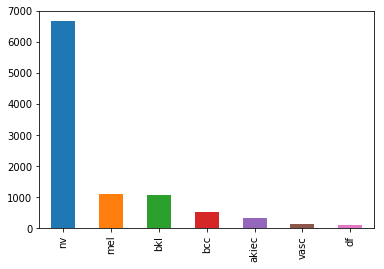

In [12]:
df['dx'].value_counts().plot(kind='bar')

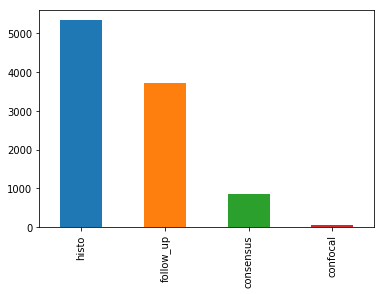

In [13]:
df['dx_type'].value_counts().plot(kind='bar')

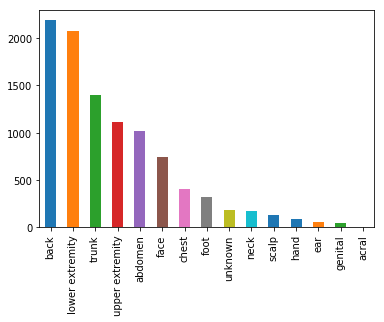

In [14]:
df['localization'].value_counts().plot(kind='bar')

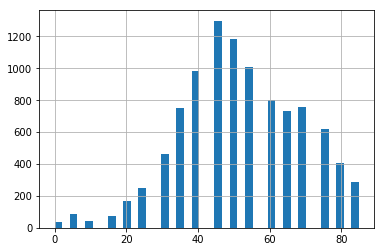

In [15]:
df['age'].hist(bins=40)

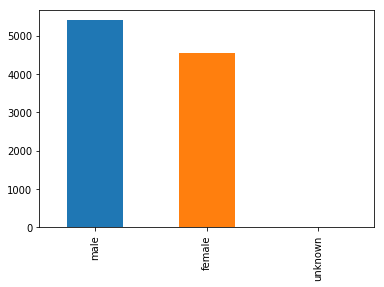

In [16]:
df['sex'].value_counts().plot(kind='bar')

In [17]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

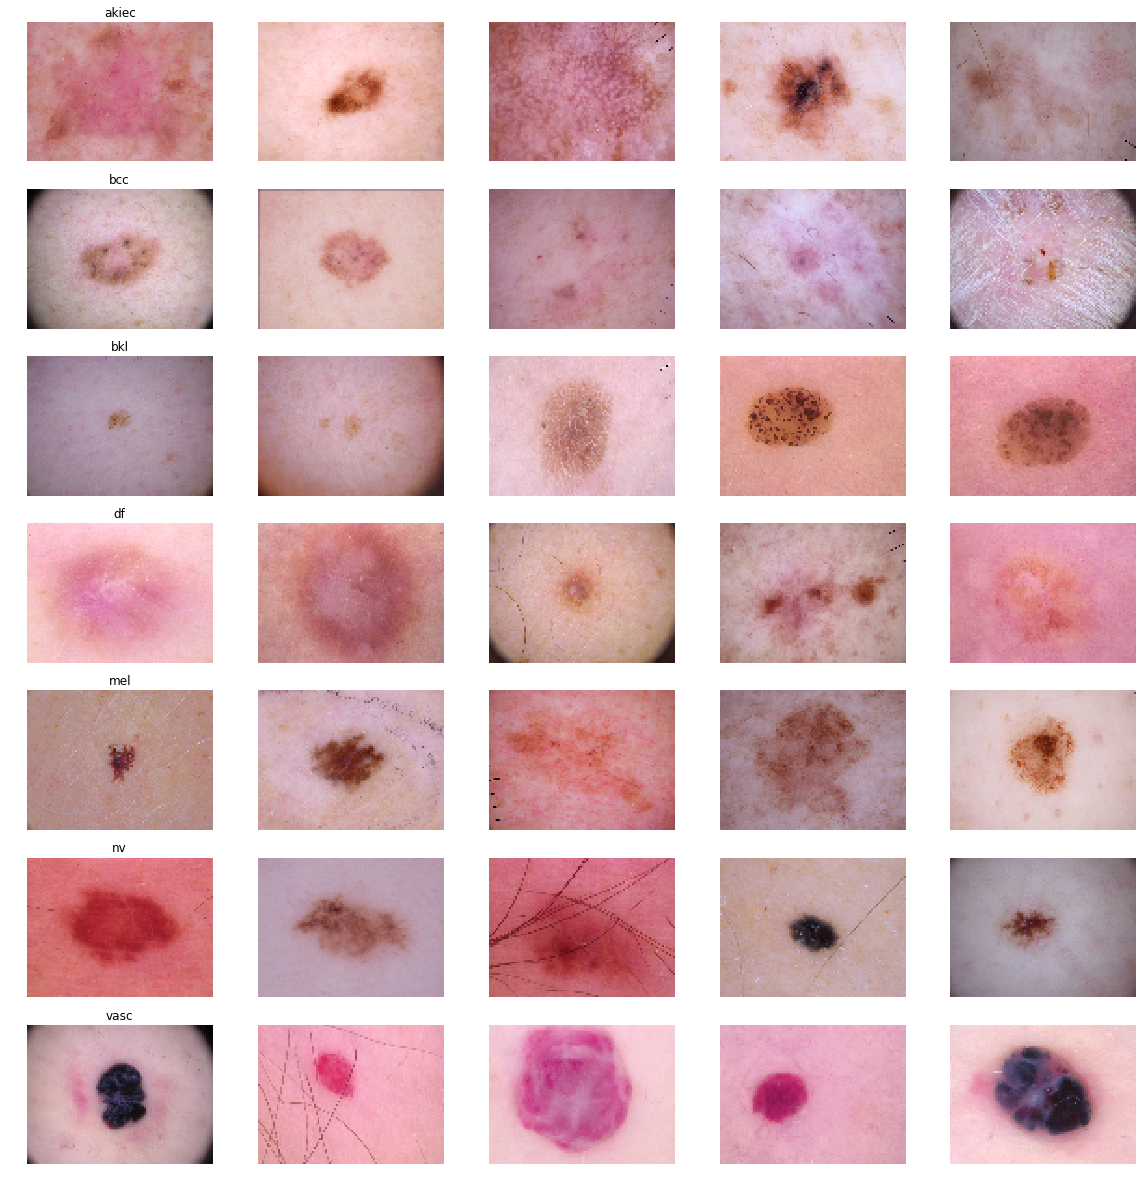

In [18]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [19]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    9958
Name: image, dtype: int64

In [20]:
features=df.drop(columns=['dx_idx'],axis=1)
target=df['dx_idx']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=1234)

In [22]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [23]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [24]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [25]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [48]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 59200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               7577728   
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
__________

In [49]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [50]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [52]:
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

In [53]:
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
716/716 [==============================] - 28s 39ms/step - loss: 1.0694 - acc: 0.6565 - val_loss: 0.8272 - val_acc: 0.6939
Epoch 2/50
716/716 [==============================] - 26s 37ms/step - loss: 0.9392 - acc: 0.6676 - val_loss: 0.8504 - val_acc: 0.7039
Epoch 3/50
716/716 [==============================] - 26s 37ms/step - loss: 0.8997 - acc: 0.6793 - val_loss: 0.7543 - val_acc: 0.7177
Epoch 4/50
716/716 [==============================] - 26s 37ms/step - loss: 0.8710 - acc: 0.6869 - val_loss: 0.7557 - val_acc: 0.7240
Epoch 5/50
716/716 [==============================] - 27s 37ms/step - loss: 0.8652 - acc: 0.6939 - val_loss: 0.7857 - val_acc: 0.7139
Epoch 6/50
716/716 [==============================] - 26s 36ms/step - loss: 0.8327 - acc: 0.6965 - val_loss: 0.7379 - val_acc: 0.7177
Epoch 7/50
716/716 [==============================] - 26s 36ms/step - loss: 0.8080 - acc: 0.7088 - val_loss: 0.7500 - val_acc: 0.7378
Epoch 8/50
716/716 [==============================] - 26s 36ms

In [54]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

797/797 [==============================] - 1s 662us/step
Validation: accuracy = 0.781681  ;  loss_v = 0.744588
Test: accuracy = 0.757028  ;  loss = 0.771682


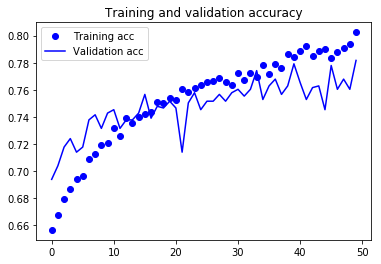

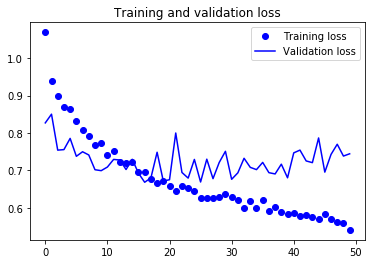

In [55]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()